__Check if spike rates of different rounds reach higher correlations when the spike rate series of one round is slightly time warped to another round.__

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import csv

import tslearn.metrics
import tslearn.preprocessing

import bee_view_analyzer.Correlation as Correlation
import bee_view_analyzer.DataLoader as DataLoader
import bee_view_analyzer.Dtw as Dtw
import bee_view_analyzer.Utils as Utils
import bee_view_analyzer.Visualizer as Visualizer

In [ ]:
csv_path = Utils.get_path(["flights", "flight_2018_09_03#1"],
                          "030918_01_out_adc_synced.csv_spike_rates_0.1s_intervalls.csv")
spike_rate = []

with open(csv_path) as csvfile:
    neuro_reader = csv.reader(csvfile)
    
    for row in neuro_reader:            
        spike_rate.append(int(row[8]))
            
spike_rate = np.array(spike_rate)

In [ ]:
start_rounds = [[630, 2900, 4580],
                [743, 2390, 4070, 5770],
                [110, 1950, 3650, 5330],
                [330, 1980, 3650, 5330]]

end_rounds = [[2120, 4370, 6050],
              [2220, 3880, 5555, 7220],
              [1600, 3440, 5150, 6795],
              [1800, 3450, 5120, 6750]]

# Observations

__All rounds seem to have one heavy spike in the center of the time series:__

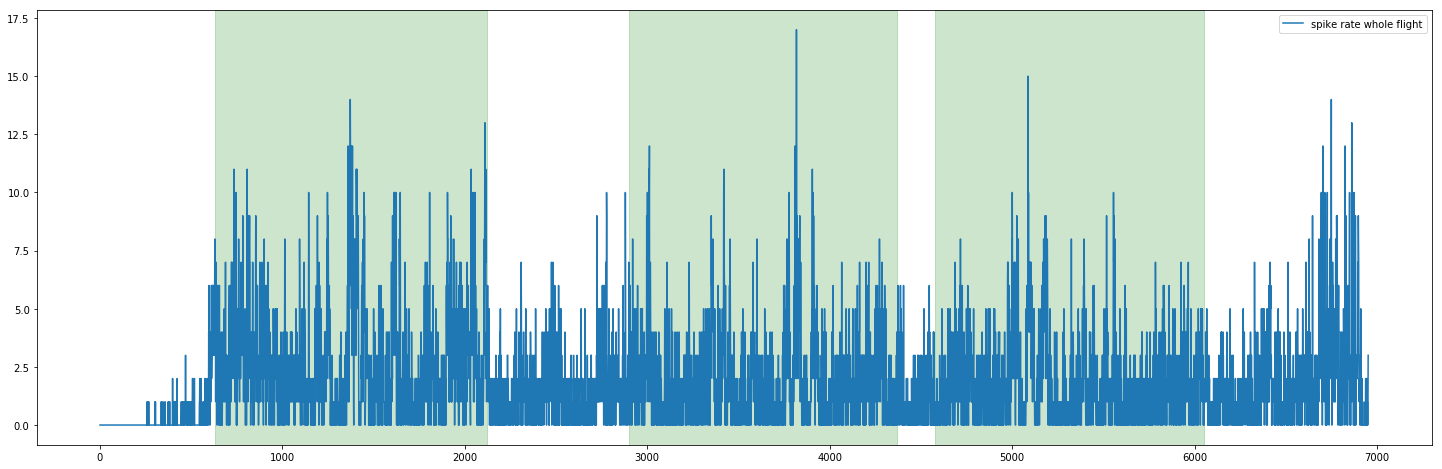

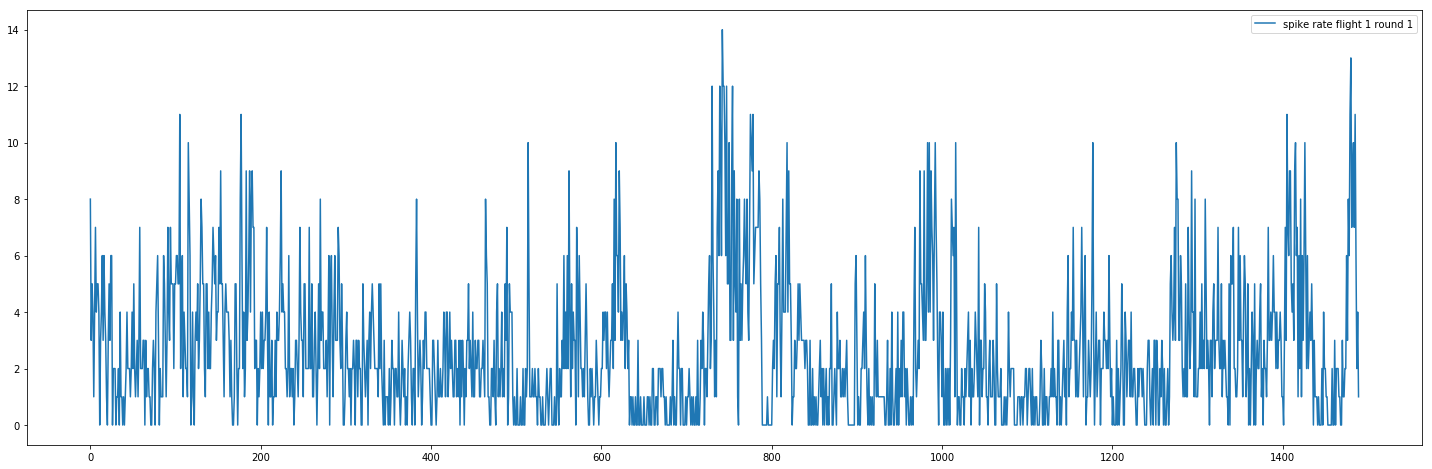

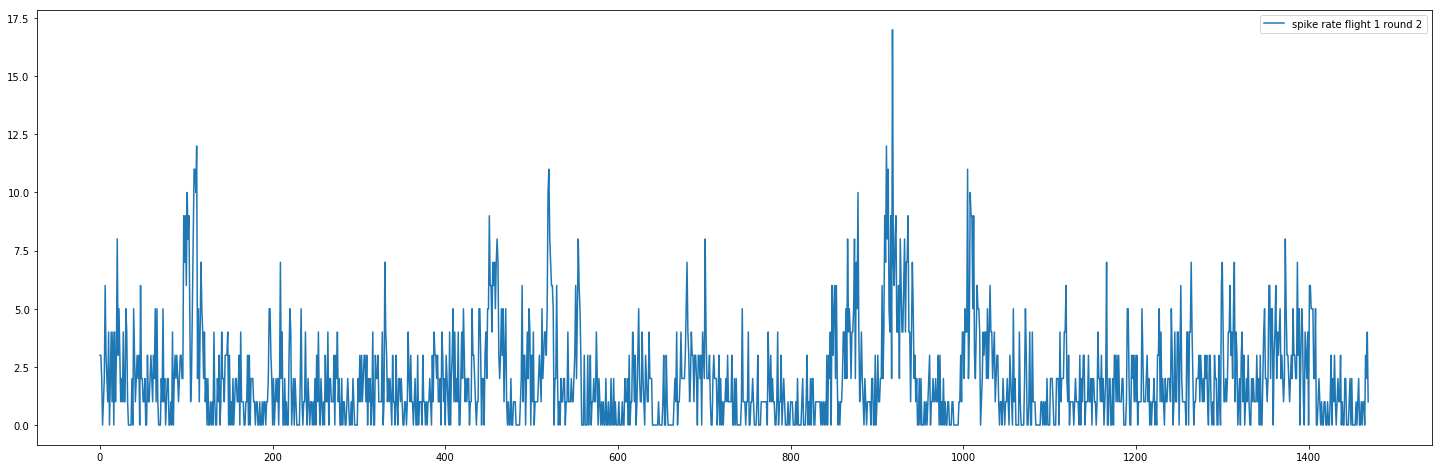

In [ ]:
Visualizer.plot(spike_rate, labels = ["spike rate whole flight"],
                highlight_regions = [start_rounds[0][0], end_rounds[0][0],
                                    start_rounds[0][1], end_rounds[0][1],
                                    start_rounds[0][2], end_rounds[0][2]])

Visualizer.plot(spike_rate, start_frame = start_rounds[0][0],
                end_frame = end_rounds[0][0], labels = ["spike rate flight 1 round 1"])

Visualizer.plot(spike_rate, start_frame = start_rounds[0][1],
                end_frame = end_rounds[0][1], labels = ["spike rate flight 1 round 2"])

__Try to move "round" window of second round such that spikes between round 1 and round 2 seem to fit:__

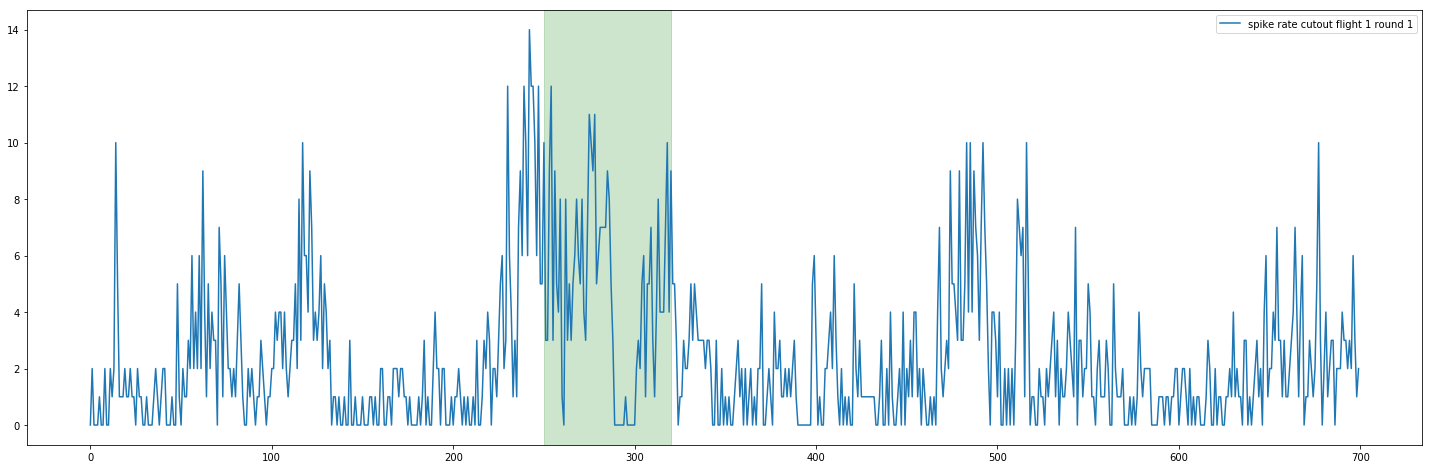

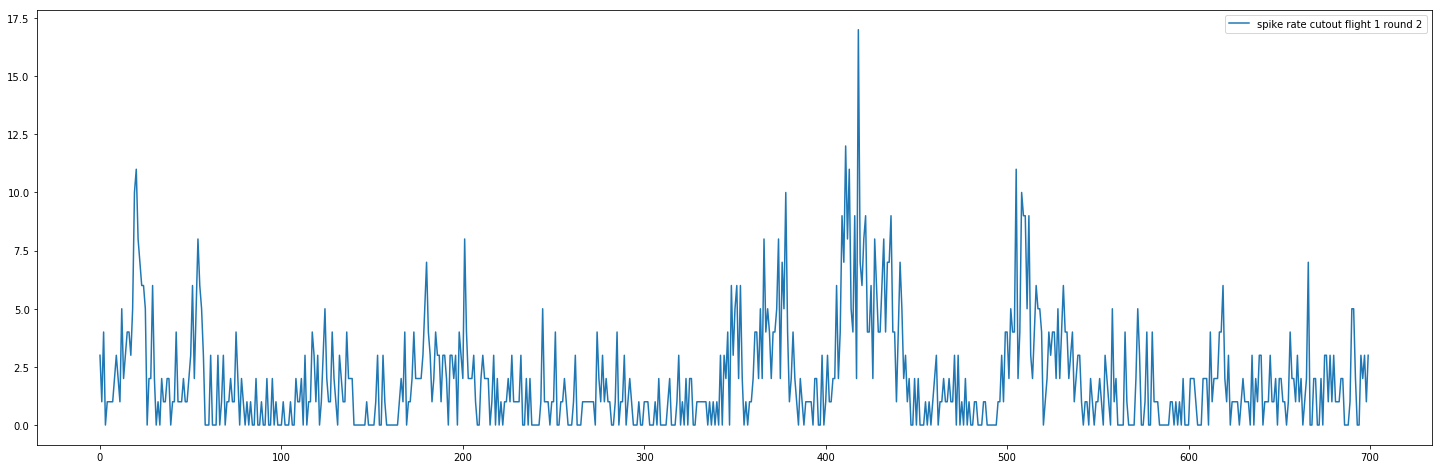

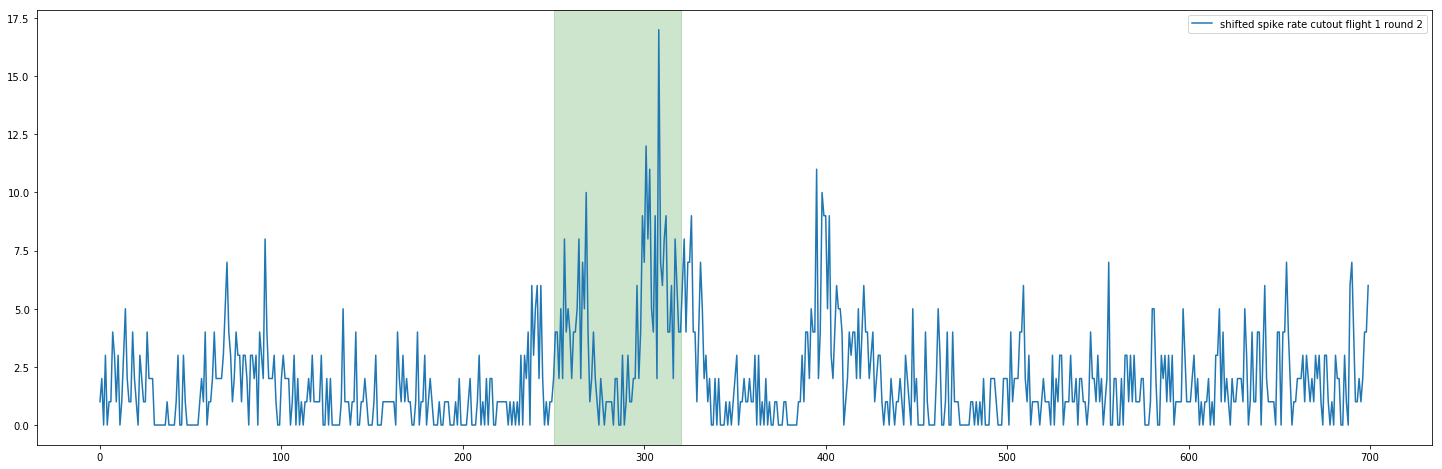

pearson round 1 x round 2:  -0.11415369003822107
pearson round 1 x shifted round 2:  0.12886335936000454


In [ ]:
offset = 110

round_1 = spike_rate[start_rounds[0][0] : end_rounds[0][0]]
round_2 = spike_rate[start_rounds[0][1] : end_rounds[0][1]]
round_2_prime = spike_rate[start_rounds[0][1] + offset : end_rounds[0][1] + offset]

start = 500
stop = 1200

highlight = [250, 320]

Visualizer.plot(round_1, start_frame = start, end_frame = stop, labels = ["spike rate cutout flight 1 round 1"],
                highlight_regions = highlight)
Visualizer.plot(round_2, start_frame = start, end_frame = stop, labels = ["spike rate cutout flight 1 round 2"])
Visualizer.plot(round_2_prime, start_frame = start, end_frame = stop,
                labels = ["shifted spike rate cutout flight 1 round 2"], highlight_regions = highlight)

print("pearson round 1 x round 2: ", Correlation._pearson(round_1[start : stop], round_2[start : stop]))
print("pearson round 1 x shifted round 2: ", Correlation._pearson(round_1[start : stop],
                                                                  round_2_prime[start : stop]))

__Search first round in rest of flight (i.e. check if time warpring finds same pattern again in following part of flight:__

In [ ]:
path, dist = tslearn.metrics.dtw_subsequence_path(round_1, spike_rate[start_rounds[0][1] - 400 :])
dist, path

(50.47771785649585,
 [(0, 805),
  (1, 805),
  (2, 805),
  (3, 805),
  (4, 805),
  (5, 805),
  (6, 805),
  (7, 805),
  (8, 805),
  (9, 805),
  (10, 805),
  (11, 806),
  (12, 807),
  (12, 808),
  (13, 809),
  (14, 809),
  (15, 809),
  (16, 809),
  (17, 809),
  (18, 810),
  (19, 810),
  (20, 810),
  (21, 811),
  (22, 811),
  (23, 811),
  (24, 811),
  (25, 811),
  (26, 812),
  (27, 813),
  (28, 813),
  (29, 813),
  (30, 814),
  (31, 814),
  (32, 814),
  (33, 814),
  (34, 814),
  (35, 815),
  (36, 816),
  (37, 817),
  (38, 817),
  (39, 817),
  (40, 817),
  (41, 818),
  (42, 818),
  (43, 818),
  (44, 818),
  (45, 818),
  (46, 818),
  (47, 818),
  (48, 818),
  (49, 819),
  (50, 819),
  (51, 819),
  (52, 820),
  (53, 820),
  (54, 820),
  (55, 820),
  (56, 820),
  (57, 820),
  (58, 821),
  (59, 822),
  (60, 822),
  (61, 822),
  (62, 822),
  (63, 822),
  (64, 823),
  (65, 824),
  (66, 824),
  (67, 824),
  (68, 824),
  (69, 825),
  (70, 825),
  (71, 825),
  (72, 825),
  (73, 826),
  (73, 827),
  

__Show cutout of found subsqeuence which is similar to first round according to dtw:__

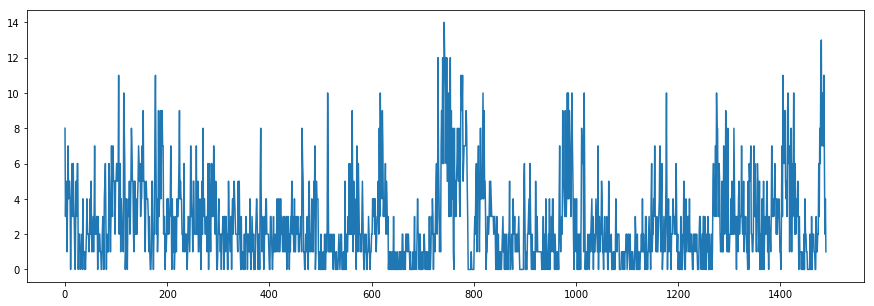

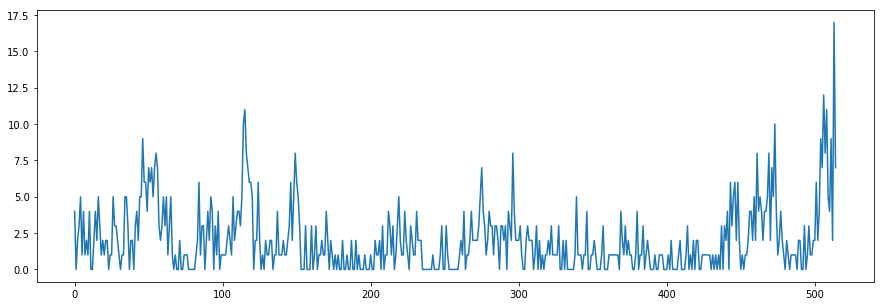

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(round_1)

plt.figure(figsize=(15, 5))
plt.plot(spike_rate[start_rounds[0][1] + 405 : start_rounds[0][1] + 920])

__Cutout is too short, this does not help. DTW distance between first round and found subsequence is quite large:__

In [ ]:
tslearn.metrics.dtw(spike_rate[start_rounds[0][1] + 405 : start_rounds[0][1] + 920], round_1)

57.83597496368502

__Enlarge second round and resample it to fit length of first round such that the peak of round 2 is at the same position as in round 1:__

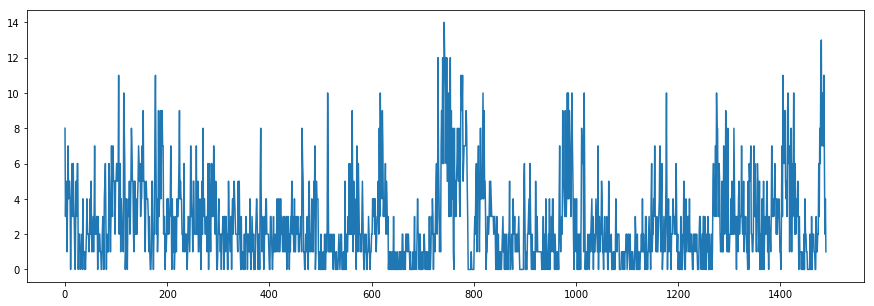

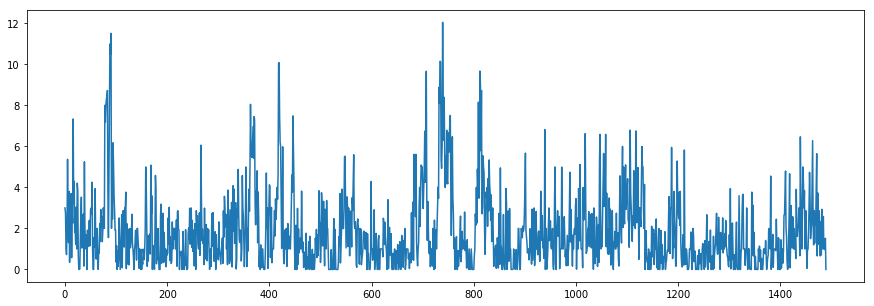

In [ ]:
enlarge_frames = len(round_1) - len(round_2) + 360
round_2_test = spike_rate[start_rounds[0][1] : end_rounds[0][1] + enlarge_frames]

round_2_resampled = tslearn.preprocessing.TimeSeriesResampler(sz = len(round_1))
round_2_resampled = round_2_resampled.fit_transform(round_2_test).flatten()

plt.figure(figsize=(15, 5))
plt.plot(round_1)

plt.figure(figsize=(15, 5))
plt.plot(round_2_resampled)

__Normalize both time series and recalculate correlation and distance values:__

In [ ]:
round_1_norm = tslearn.preprocessing.TimeSeriesScalerMinMax(min=0., max=1.).fit_transform(round_1).flatten()

round_2_norm = tslearn.preprocessing.TimeSeriesScalerMinMax(min=0., max=1.)
round_2_norm = round_2_norm.fit_transform(round_2_resampled).flatten()

print("pearson: ", Correlation._pearson(round_1_norm[:len(round_2_norm)], round_2_norm))
print("dtw: ", tslearn.metrics.dtw(round_1_norm[:len(round_2_norm)], round_2_norm))

pearson:  0.07597675483988517
dtw:  3.795073269138428


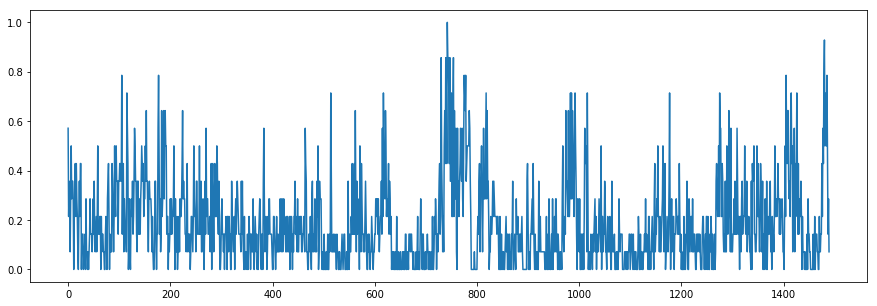

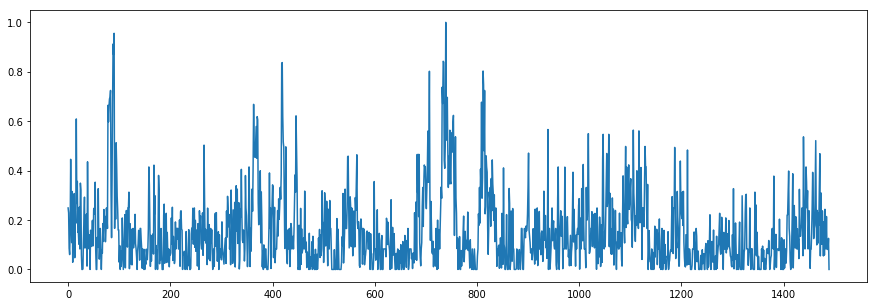

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(round_1_norm)

plt.figure(figsize=(15, 5))
plt.plot(round_2_norm)

__Visualize how the second round is stretched and contracted to fit to first round:__

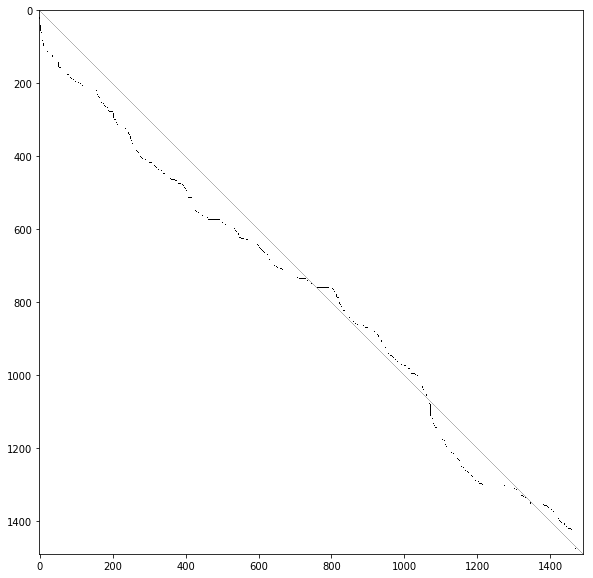

In [ ]:
path, sim = tslearn.metrics.dtw_path(round_1_norm[:len(round_2_norm)], round_2_norm)

size = len(round_2_norm)
matrix_path = np.zeros((size, size), dtype = np.float)
for i, j in path:
    matrix_path[i, j] = 1
    
for i in np.arange(size):
    matrix_path[i, i] = 0.3
    
plt.figure(figsize=(10, 10))
plt.imshow(matrix_path, cmap="gray_r")

__Visualize time warped round 2:__

In [ ]:
round_2_warped = []

current_round_1_frame = -1

for round_1_frame, round_2_frame in path:
    if current_round_1_frame == round_1_frame:
        continue
        
    current_round_1_frame = round_1_frame
    round_2_warped.append(round_2_norm[round_2_frame])

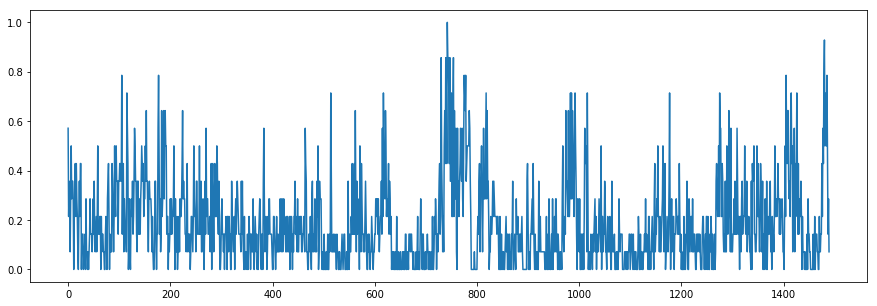

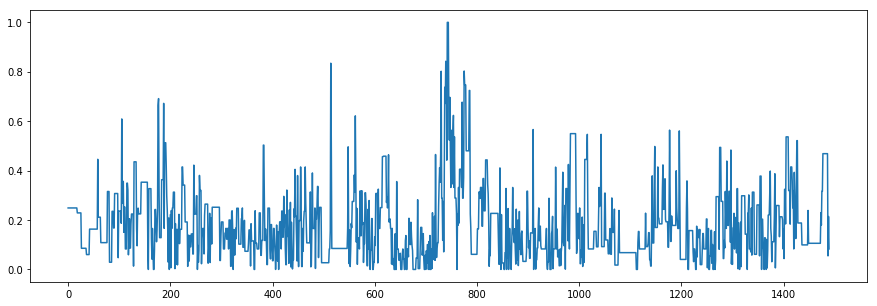

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(round_1_norm)

plt.figure(figsize=(15, 5))
plt.plot(round_2_warped)

__Correlation value of first round and time-warped second round:__

In [ ]:
Correlation._pearson(round_1_norm, round_2_warped)

0.8656195213527135

# Time warping all rounds of first flight

__Scaling rounds does not change pearson correlation values. Resampling changes pearson slightly when one time series is stretched/shortened (here, only round 1 is shortened, so correlation of round 2 and 3 remains the same). Tables are symmetric!__

In [ ]:
round_1 = spike_rate[start_rounds[0][0] : end_rounds[0][0]]
round_2 = spike_rate[start_rounds[0][1] : end_rounds[0][1]]
round_3 = spike_rate[start_rounds[0][2] : end_rounds[0][2]]

rounds = [round_1, round_2, round_3]

Dtw.show_corr_table(rounds)

,Round 1,Round 2,Round 3
Round 1,1.000000,-0.047996,0.001289
Round 2,-0.047996,1.000000,0.031855
Round 3,0.001289,0.031855,1.000000


In [ ]:
rounds_scaled = Dtw.scale(rounds)
Dtw.show_corr_table(rounds_scaled)

,Round 1,Round 2,Round 3
Round 1,1.000000,-0.047996,0.001289
Round 2,-0.047996,1.000000,0.031855
Round 3,0.001289,0.031855,1.000000


In [ ]:
rounds_resampled = Dtw.resample(rounds)
Dtw.show_corr_table(rounds_resampled)

,Round 1,Round 2,Round 3
Round 1,1.000000,-0.051371,0.029189
Round 2,-0.051371,1.000000,0.031855
Round 3,0.029189,0.031855,1.000000


__Resampling to same length does not influence correlation value:__

In [ ]:
Correlation._pearson(rounds_resampled[1], rounds[1])

1.0

__DTW paths betwenn all 3 rounds seem to be near perfect line:__

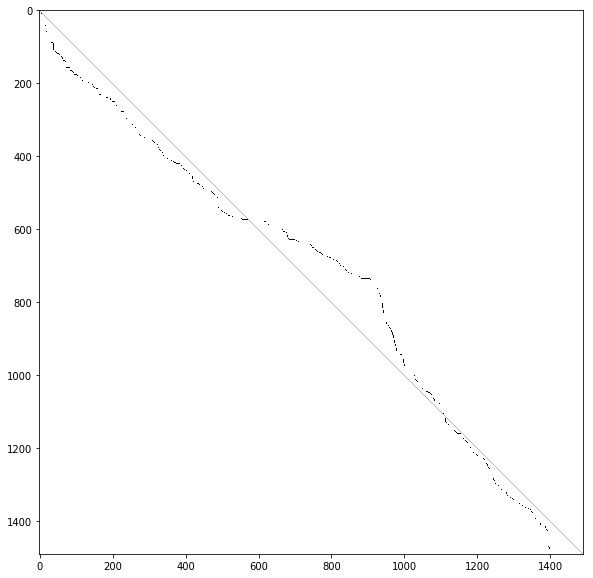

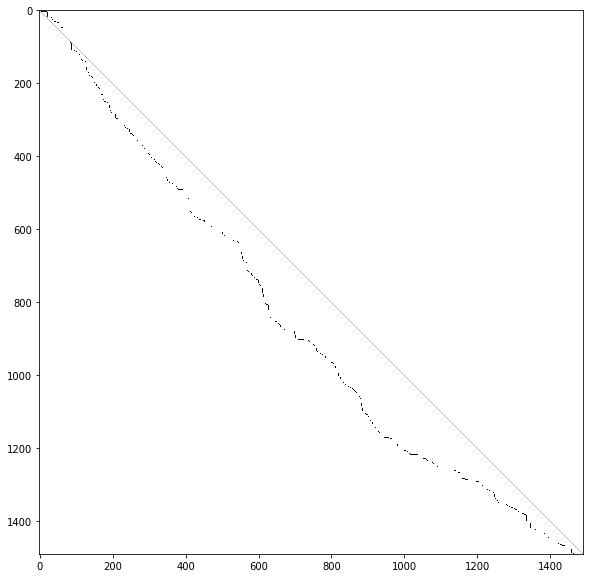

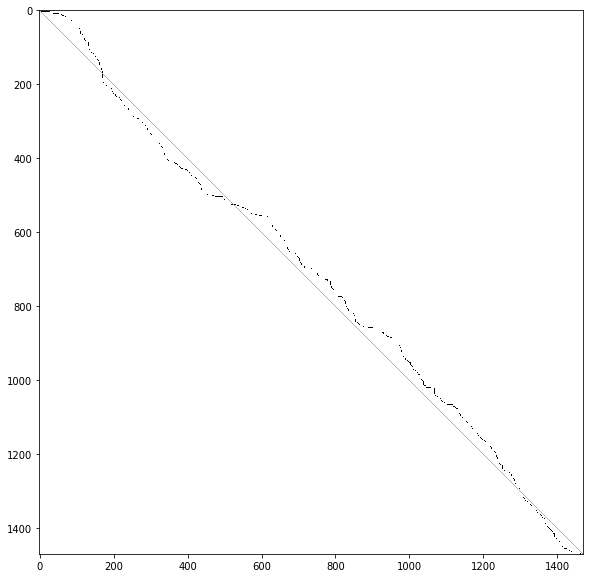

In [ ]:
Dtw.show_dtw_path(rounds[0], rounds[1])
Dtw.show_dtw_path(rounds[0], rounds[2])
Dtw.show_dtw_path(rounds[1], rounds[2])

__Swapping base and warp series mirrors path along diagonal line:__

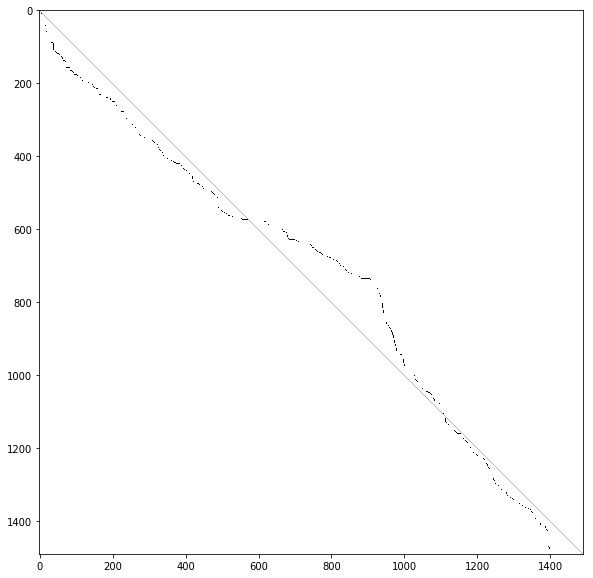

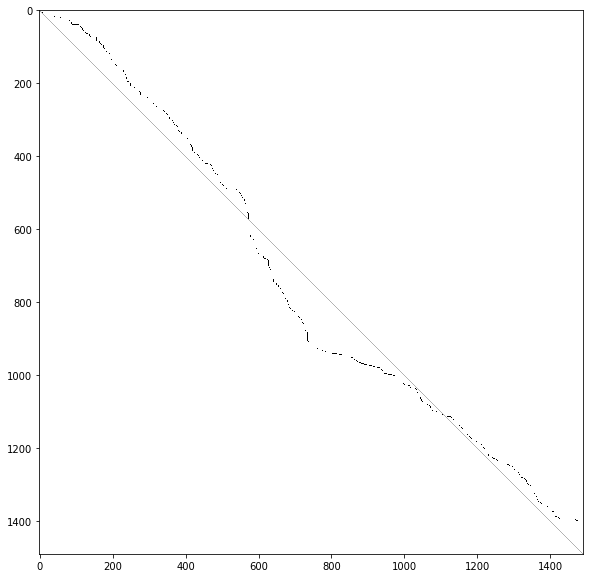

In [ ]:
Dtw.show_dtw_path(rounds[0], rounds[1])
Dtw.show_dtw_path(rounds[1], rounds[0])

__Using scaled series changes path slightly:__

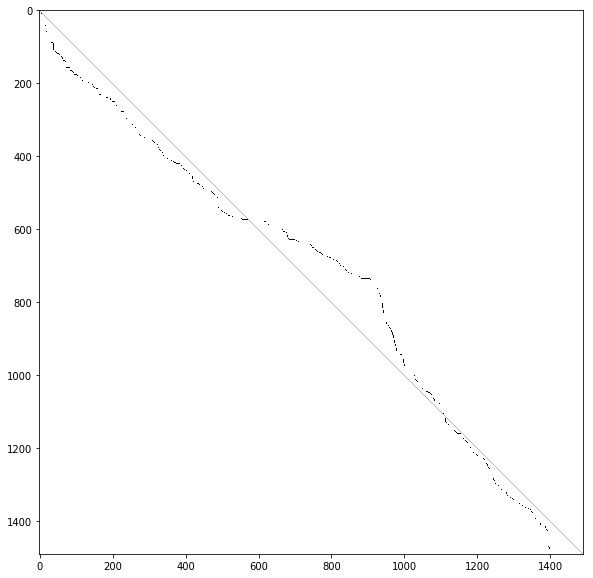

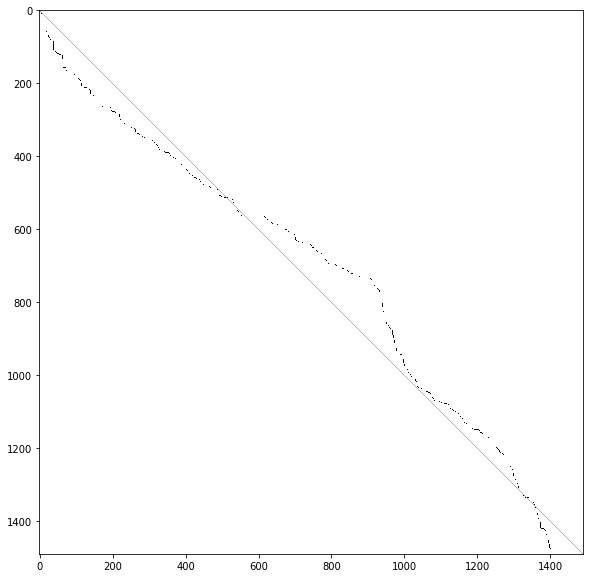

In [ ]:
Dtw.show_dtw_path(rounds[0], rounds[1])
Dtw.show_dtw_path(rounds_scaled[0], rounds_scaled[1])

__High correlation value remains after swapping warped series:__

0.8780002072412401

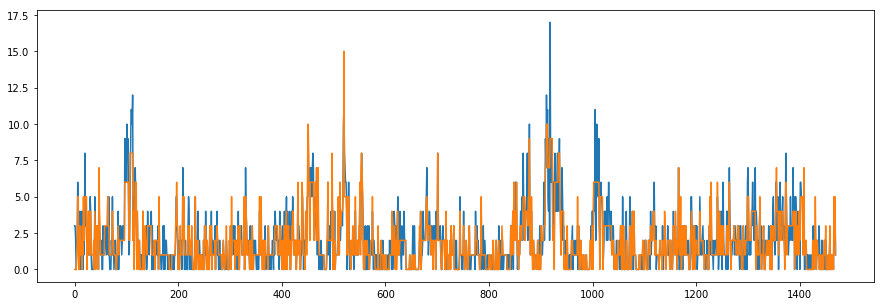

In [ ]:
Dtw.plot_warped_series(rounds[1], rounds[2])
Dtw.correlate_warped_series(rounds[1], rounds[2])

0.8740317387673089

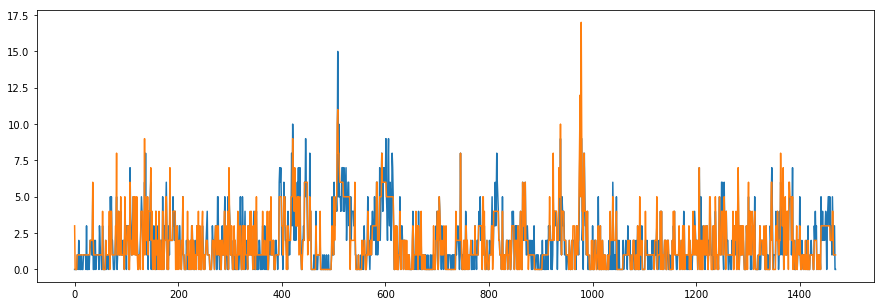

In [ ]:
Dtw.plot_warped_series(rounds[2], rounds[1])
Dtw.correlate_warped_series(rounds[2], rounds[1])

__Pearson values are high regardless of warped round:__

In [ ]:
Dtw.show_warped_corr_table(rounds)

,Warped round 1,Warped round 2,Warped round 3
Round 1,1.000000,0.864050,0.845412
Round 2,0.874797,1.000000,0.878000
Round 3,0.864141,0.874032,1.000000


__But: Mean divergence of stretching or shortening is high (up to 11 seconds!)__

In [ ]:
Dtw.show_warped_divergence_table(rounds, mean = True)

,Warped round 1,Warped round 2,Warped round 3
Round 1,0.303960,54.705857,114.515415
Round 2,54.926522,0.381557,33.145291
Round 3,114.986516,33.185433,0.398374


__Max divergence of stretching or shortening is up to 23 seconds!__

In [ ]:
Dtw.show_warped_divergence_table(rounds, mean = False)

,Warped round 1,Warped round 2,Warped round 3
Round 1,7,170,228
Round 2,170,6,71
Round 3,228,70,6


__Use Sakoechiba constraint to prevent too much distortion during warping. Pearson value after warping does not decrease much until Sakoechiba is really small:__

window size:  10
pearson after warping:  0.7235899176354512
mean/max warping divergence:  (10.18719646799117, 29)


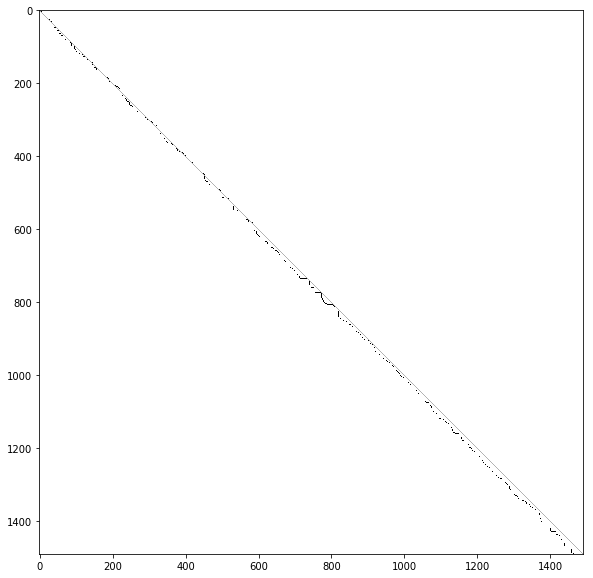

In [ ]:
window_size = 10

Dtw.show_dtw_path(round_1, round_3, window_size)

print("window size: ", window_size)
print("pearson after warping: ", Dtw.correlate_warped_series(round_1, round_3, window_size))
print("mean/max warping divergence: ", Dtw.get_warp_divergence(round_1, round_3, window_size))

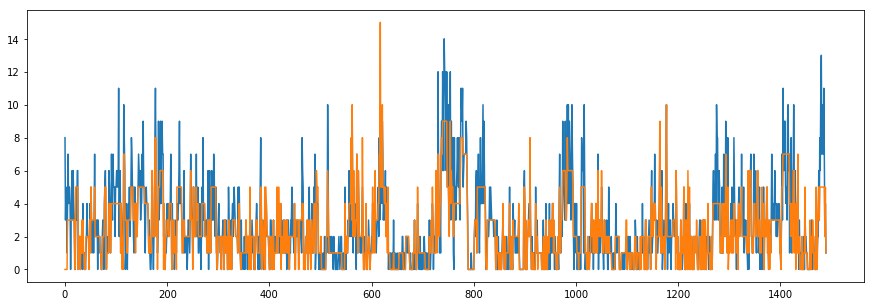

In [ ]:
Dtw.plot_warped_series(round_1, round_3, 10)

__Plot scaled warped series with Sakoechiba constraint:__

window size:  10


0.7056604521960677

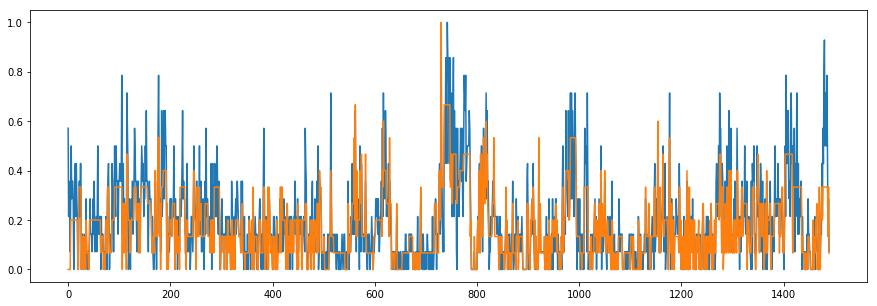

In [ ]:
print("window size: ", 10)
Dtw.plot_warped_series(rounds_scaled[0], rounds_scaled[2], 10)
Dtw.correlate_warped_series(rounds_scaled[0], rounds_scaled[2], 10)

__Visualizations with other libraries (dtwalign has strange distance values!):__

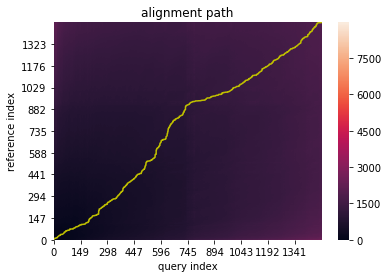

In [ ]:
Dtw.show_dtw_path(round_1, round_2, mode = 1)

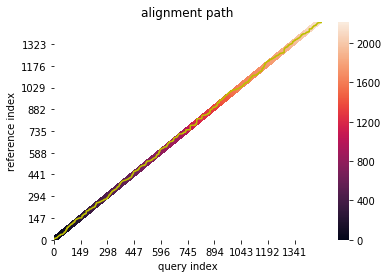

In [ ]:
Dtw.show_dtw_path(round_1, round_2, window_size = 20, mode = 1)

distance:  54.20332093147061
distance (fast calculation):  54.20332093147061


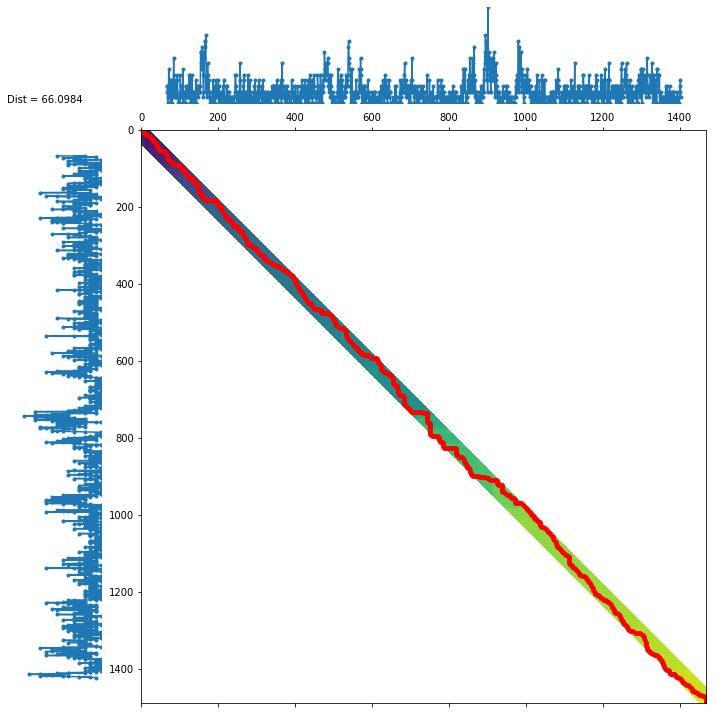

In [ ]:
print("distance: ", Dtw.distance(round_1, round_2, mode = 0))
print("distance (fast calculation): ", Dtw.distance(round_1, round_2, mode = 1))

Dtw.show_dtw_path(round_1, round_2, window_size = 20, mode = 2)

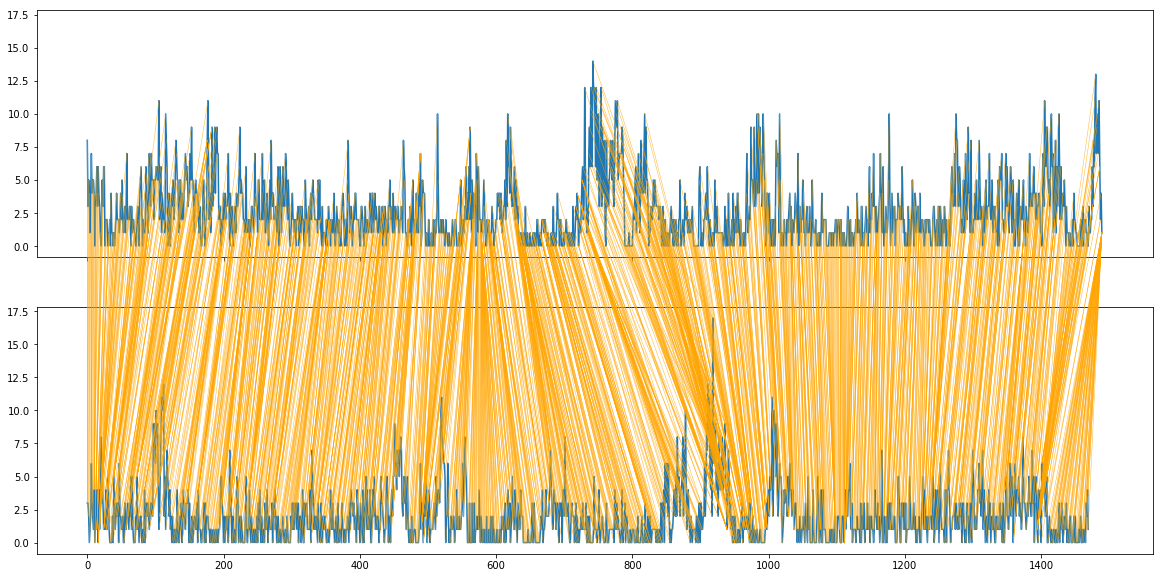

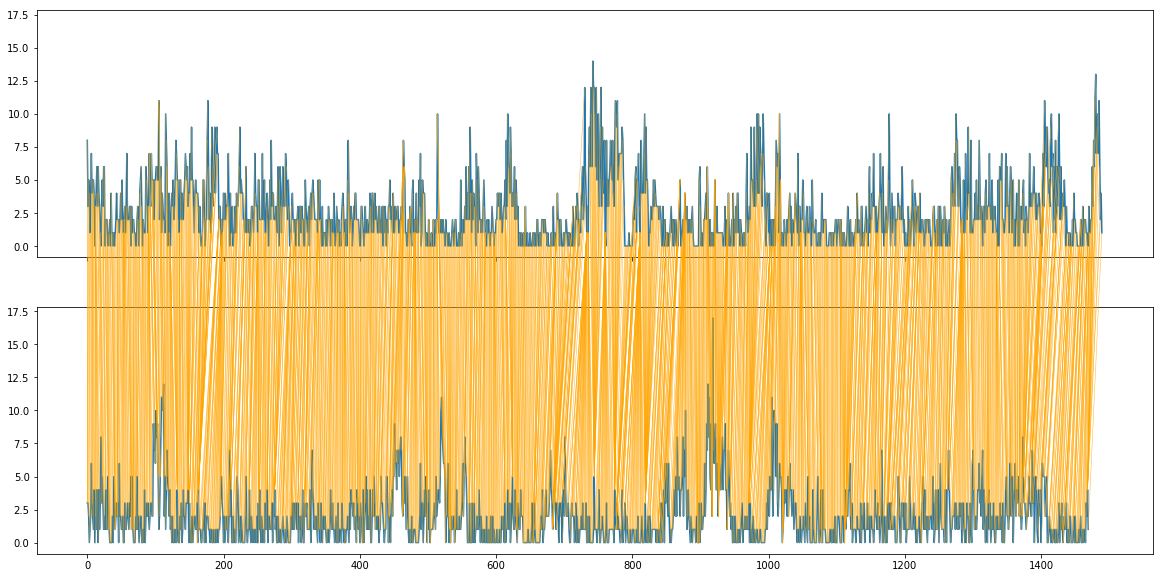

In [ ]:
Dtw.show_warping(round_1, round_2)
Dtw.show_warping(round_1, round_2, window_size = 10)

__Use z-normalization to compare only shape (not absolute differences and offset):__

0.7565463806314766

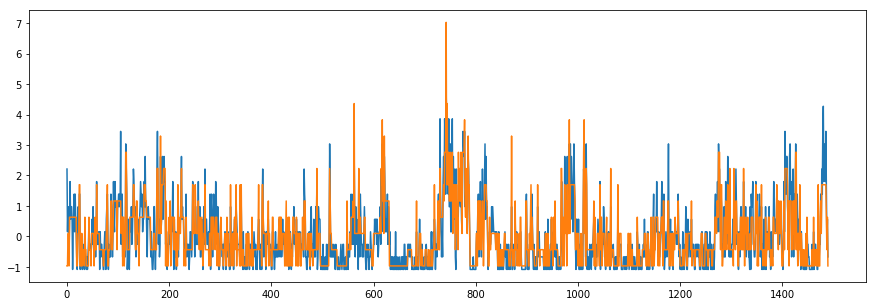

In [ ]:
rounds_normed = Dtw.znorm(rounds)

Dtw.plot_warped_series(rounds_normed[0], rounds_normed[2], 10)
Dtw.correlate_warped_series(rounds_normed[0], rounds_normed[2], 10)

In [ ]:
Dtw.show_corr_table(rounds_normed)

,Round 1,Round 2,Round 3
Round 1,1.000000,-0.047996,0.001289
Round 2,-0.047996,1.000000,0.031855
Round 3,0.001289,0.031855,1.000000


In [ ]:
Dtw.show_warped_corr_table(rounds_normed, window_size = 10)

,Warped round 1,Warped round 2,Warped round 3
Round 1,1.000000,0.731032,0.756546
Round 2,0.729397,1.000000,0.789193
Round 3,0.752175,0.744552,1.000000


In [ ]:
Dtw.show_warped_divergence_table(rounds_normed, window_size = 10)

,Warped round 1,Warped round 2,Warped round 3
Round 1,0.303960,11.107663,10.319312
Round 2,10.990575,0.381557,4.284058
Round 3,10.206485,4.281159,0.398374
